# 🐶📊 Détection et Explication des Maladies Cardiaques chez le Chien par Deep Learning

---

## 🎯 Objectifs du Projet

Ce projet vise à :

- Classifier automatiquement les radiographies thoraciques de chiens en trois catégories cliniques :  
  **0 = Sain**, **1 = Réduction cardiaque légère**, **2 = Pathologie grave (cardiomégalie)**  
- Comparer plusieurs architectures CNN modernes (ResNet, DenseNet, EfficientNet, ViT, ConvNeXt)
- Visualiser les zones activées par le modèle via **Grad-CAM**
- Générer un **rapport PDF explicatif** combinant images, erreurs, et analyse visuelle
- Intégrer une **recommandation IA médicale** locale (via Mistral et Ollama) pour expliquer la prédiction et conseiller le vétérinaire

---

## 👩‍💻 Auteure

- **Dorra Sioud**  
  Étudiante passionnée par l'IA médicale appliquée au domaine vétérinaire 🧠🐾  
  Projet réalisé dans le cadre d’un atelier IA avancée — 2025  
  Modèle IA local utilisé : `Mistral` via `Ollama`

---

## 🧠 Technologies utilisées

- PyTorch, Torchvision, TorchCam  
- Scikit-learn, Matplotlib, PIL, CV2  
- Hugging Face datasets & Mendeley dataset  
- Modèles pré-entraînés CNN et ViT  
- API locale Mistral avec Ollama pour IA explicative

---

> Ce notebook illustre une approche complète de **classification, visualisation, explication et recommandation** pour améliorer la prise de décision vétérinaire à partir de radiographies.


In [1]:
#Bloc 1 — Importation des bibliothèques
import os
import torch
import torchvision.transforms as transforms
import torchvision.models as models
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler, random_split
from torch import nn, optim
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np
from datasets import load_dataset
from PIL import Image
import random
import shutil
import cv2
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import pandas as pd
from torchcam.methods import GradCAM
import matplotlib.cm as cm

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [2]:
# Bloc 2 — Chargement du dataset Hugging Face

# Chargement du dataset depuis Hugging Face
hf_dataset = load_dataset("aditya11997/dog_heart_xray_data", split="train")

print(f"✅ Nombre total d'exemples chargés : {len(hf_dataset)}")

# Aperçu rapide d'un exemple
example = hf_dataset[0]
print("\n📝 Description associée :", example["text"])
example["image"].show()

✅ Nombre total d'exemples chargés : 208

📝 Description associée : In the dog's chest X-ray and the chest x-ray shows a diminished heart outline.


In [3]:
# Bloc 3 — Extraction de tous les textes uniques

# Extraire tous les textes du dataset
all_texts = [ex["text"].strip().lower() for ex in hf_dataset]

# Afficher les 10 premiers pour un aperçu
print("✅ Voici un aperçu de 10 textes :\n")
for i, text in enumerate(all_texts[:10]):
    print(f"[{i}] {text}")

# Afficher le nombre total de textes uniques
print(f"\nNombre de textes uniques : {len(set(all_texts))}")

# Lister tous les textes uniques
print("\n--- Textes uniques trouvés ---")
for i, text in enumerate(sorted(set(all_texts))):
    print(f"{i+1}. {text}")

✅ Voici un aperçu de 10 textes :

[0] in the dog's chest x-ray and the chest x-ray shows a diminished heart outline.
[1] in the dog's chest x-ray and a reduced cardiac silhouette is evident in the chest x-ray.
[2] in the dog's chest x-ray, a diminutive heart structure is observed, warranting an in-depth examination.
[3] a reduced heart size is visible in the canine thoracic x-ray and thoracic x-ray revealing a smaller cardiac silhouette.
[4] the chest x-ray shows a diminished heart outline and thoracic x-ray revealing a smaller cardiac silhouette.
[5] an x-ray displaying a snug heart size and a reduced cardiac silhouette is evident in the chest x-ray.
[6] the canine chest x-ray shows a small heart and an x-ray displaying a snug heart size.
[7] compact heart size noted in x-ray and a reduced cardiac silhouette is evident in the chest x-ray.
[8] a reduced heart size is visible in the canine thoracic x-ray and thoracic x-ray revealing a smaller cardiac silhouette.
[9] the x-ray reveals a 

In [4]:
# Bloc 4 — Conversion des textes en labels multiclasses

# Map des mots clés vers une classe clinique
def mapper_multiclasses(text):
    text = text.lower()

    if any(kw in text for kw in ["compact heart", "snug heart", "small heart"]):
        return 0   # 🩺 Classe 0 : coeur compact (sain)
    
    elif any(kw in text for kw in ["diminished heart", "reduced heart", "reduced cardiac silhouette"]):
        return 1   # ❤️ Classe 1 : taille réduite (petite anomalie)
    
    elif any(kw in text for kw in ["cardiomegaly", "possible ailment", "evaluation", "enlarged heart"]):
        return 2   # ⚡ Classe 2 : pathologie possible (anomalie sérieuse)
    
    else:
        return 1   # (Par défaut, si aucun mot clé trouvé, classer dans "taille réduite" pour éviter les erreurs)

# Appliquer la fonction à tous les textes
multi_labels = [mapper_multiclasses(txt) for txt in all_texts]

from collections import Counter
print("📊 Nouvelle répartition des classes :", Counter(multi_labels))

📊 Nouvelle répartition des classes : Counter({0: 148, 1: 60})


✅ Nombre d'images Mendeley chargées : 142


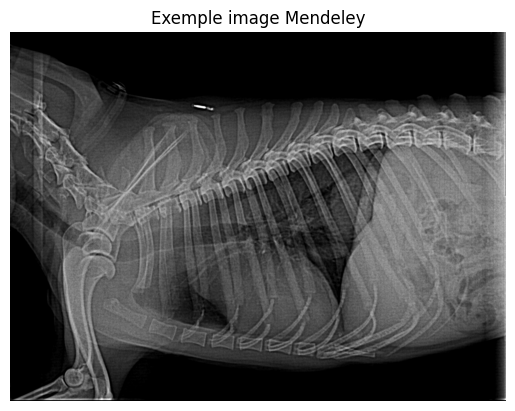

In [5]:
# Bloc 5 — Chargement du dataset Mendeley (maladies cardiaques graves)

# Dossier où sont stockées les images de Mendeley
mendeley_folder = "./VHS_dataset"   # Remplace par ton chemin correct si différent

# Liste des images
mendeley_filenames = [f for f in os.listdir(mendeley_folder) if f.endswith('.png')]

print(f"✅ Nombre d'images Mendeley chargées : {len(mendeley_filenames)}")

# Vérification d'un exemple
img_example = Image.open(os.path.join(mendeley_folder, mendeley_filenames[0]))
plt.imshow(img_example, cmap='gray')
plt.title("Exemple image Mendeley")
plt.axis('off')
plt.show()

In [6]:
# Bloc 6 — Fusionner Hugging Face + Mendeley en un seul dataset PyTorch(Dataset personnalisé combiné)

class CombinedDogXrayDataset(Dataset):
    def __init__(self, hf_dataset, hf_labels, mendeley_folder, mendeley_filenames, transform=None):
        self.hf_dataset = hf_dataset
        self.hf_labels = hf_labels
        self.mendeley_folder = mendeley_folder
        self.mendeley_filenames = mendeley_filenames
        self.transform = transform
        self.total_len = len(hf_dataset) + len(mendeley_filenames)

    def __len__(self):
        return self.total_len

    def __getitem__(self, idx):
        if idx < len(self.hf_dataset):
            image = self.hf_dataset[idx]["image"]
            label = self.hf_labels[idx]
            if image.mode != 'RGB':
                image = image.convert('RGB')
        else:
            idx_mend = idx - len(self.hf_dataset)
            image_path = os.path.join(self.mendeley_folder, self.mendeley_filenames[idx_mend])
            image = Image.open(image_path).convert('RGB')
            label = 2  # Anomalie grave pour Mendeley

        if self.transform:
            image = self.transform(image)

        return image, label

# Instancier sans transformation ici
combined_dataset = CombinedDogXrayDataset(
    hf_dataset, multi_labels, mendeley_folder, mendeley_filenames, transform=None
)          

In [7]:
# ❌ Ne pas appliquer de transformation ici (important pour ne pas altérer val/test)
transform = None

# Dataset combiné (fusion Hugging Face + Mendeley)
combined_dataset = CombinedDogXrayDataset(
    hf_dataset=hf_dataset,
    hf_labels=multi_labels,
    mendeley_folder=mendeley_folder,
    mendeley_filenames=mendeley_filenames,
    transform=transform
)

print(f"✅ Dataset combiné créé avec {len(combined_dataset)} images (HF + Mendeley)")

✅ Dataset combiné créé avec 350 images (HF + Mendeley)


In [8]:
# Vérification rapide
img, lbl = combined_dataset[0]
print(f"Image size : {img.size}, Label : {lbl}")

Image size : (835, 542), Label : 1


📊 Répartition finale des classes : Counter({0: 148, 2: 142, 1: 60})


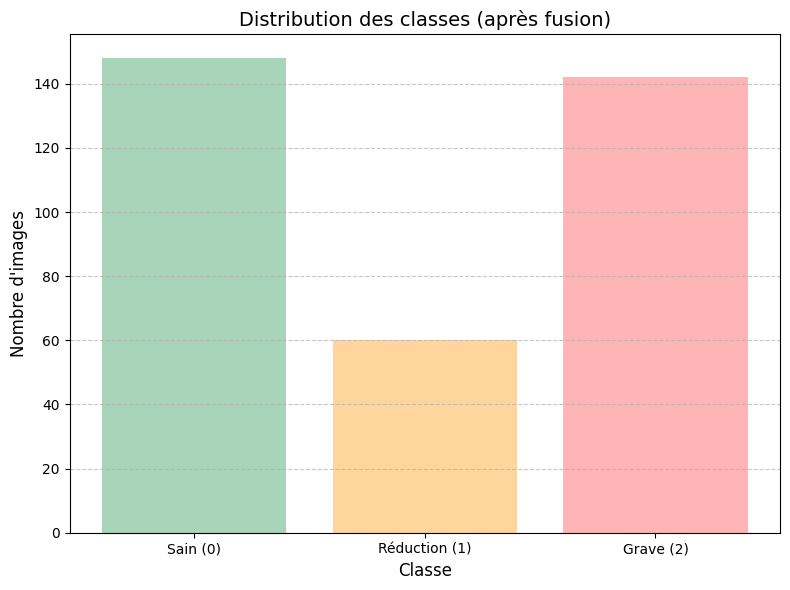

In [9]:
# Vérifier la répartition finale des classes

from collections import Counter
import matplotlib.pyplot as plt

# Collecter tous les labels du dataset fusionné
all_labels = [combined_dataset[i][1] for i in range(len(combined_dataset))]

# Compter les labels
counter = Counter(all_labels)
print(f"📊 Répartition finale des classes :", counter)

pastel_colors = {
    0: "#A8D5BA",  # Vert pastel clair pour "Sain"
    1: "#FFD59E",  # Orange pastel pour "Réduction"
    2: "#FFB5B5",  # Rouge rosé pastel pour "Grave"
}

# Afficher le graphe
plt.figure(figsize=(8, 6))
plt.bar(
    ["Sain (0)", "Réduction (1)", "Grave (2)"],
    [148, 60, 142],
    color=[pastel_colors[0], pastel_colors[1], pastel_colors[2]]
)
plt.title("Distribution des classes (après fusion)", fontsize=14)
plt.xlabel("Classe", fontsize=12)
plt.ylabel("Nombre d'images", fontsize=12)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

In [10]:
from torch.utils.data import Subset
from torch.utils.data import WeightedRandomSampler

# 1. Définir les transformations
transform_train = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.ToTensor()
])

transform_val = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])

# 2. Séparer les indices (pas les objets directement)
total_size = len(combined_dataset)
val_size = int(0.2 * total_size)
train_size = total_size - val_size
generator = torch.Generator().manual_seed(42)  # reproductibilité

train_indices, val_indices = random_split(range(total_size), [train_size, val_size], generator=generator)

# 3. Appliquer les transformations à chaque sous-dataset via Subset
class TransformedSubset(Dataset):
    def __init__(self, base_dataset, indices, transform=None):
        self.base_dataset = base_dataset
        self.indices = indices
        self.transform = transform

    def __len__(self):
        return len(self.indices)

    def __getitem__(self, idx):
        image, label = self.base_dataset[self.indices[idx]]
        if self.transform:
            image = self.transform(image)
        return image, label

# 4. Créer les datasets transformés
train_dataset = TransformedSubset(combined_dataset, train_indices, transform=transform_train)
val_dataset = TransformedSubset(combined_dataset, val_indices, transform=transform_val)

# 5. Équilibrer le train_dataset avec WeightedRandomSampler
targets = [combined_dataset[i][1] for i in train_indices]
class_counts = Counter(targets)
class_weights = {cls: 1.0 / count for cls, count in class_counts.items()}
sample_weights = [class_weights[label] for label in targets]

sampler = WeightedRandomSampler(weights=sample_weights, num_samples=len(sample_weights), replacement=True)

# 6. DataLoaders
batch_size = 16
train_loader = DataLoader(train_dataset, batch_size=batch_size, sampler=sampler)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

print(f"✅ Taille Train : {len(train_dataset)} | Taille Validation : {len(val_dataset)}")

✅ Taille Train : 280 | Taille Validation : 70


In [11]:
#Bloc 6 — Amélioration : Data Augmentation Avancée

transform_train = transforms.Compose([
    transforms.RandomResizedCrop(224, scale=(0.85, 1.0)),
    transforms.RandomApply([
        transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1)
    ], p=0.5),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomVerticalFlip(p=0.1),
    transforms.RandomRotation(degrees=15),
    transforms.RandomAffine(degrees=0, translate=(0.05, 0.05)),
    transforms.RandomPerspective(distortion_scale=0.2, p=0.3),
    transforms.GaussianBlur(kernel_size=3, sigma=(0.1, 1.0)),
    transforms.ToTensor(),
])

transform_val = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

print("🎨 ✅ Nouvelles transformations améliorées appliquées !")

🎨 ✅ Nouvelles transformations améliorées appliquées !


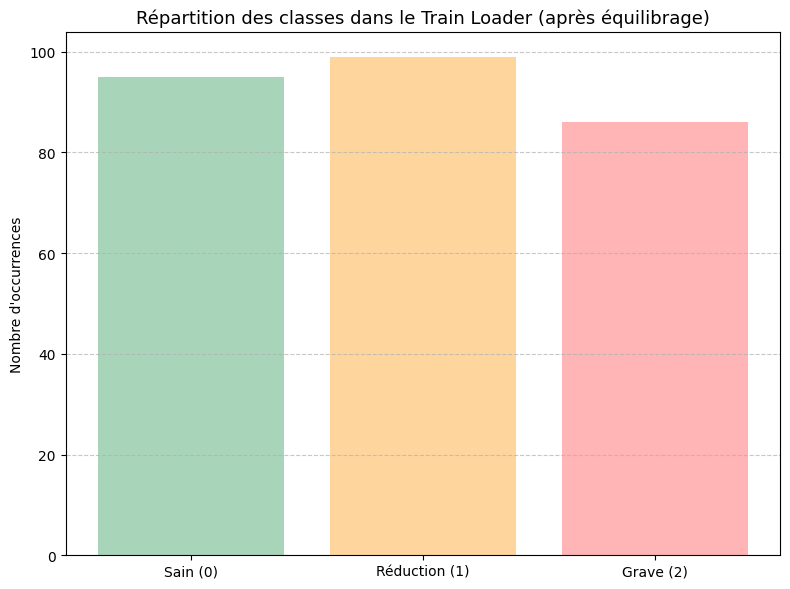

In [12]:
from collections import Counter
import matplotlib.pyplot as plt

def count_labels_from_loader(dataloader, max_batches=None):
    label_list = []
    for i, (_, labels) in enumerate(dataloader):
        label_list.extend(labels.tolist())
        if max_batches and i+1 >= max_batches:
            break
    return Counter(label_list)

# 📊 Compter les classes dans le train loader
train_counter = count_labels_from_loader(train_loader, max_batches=100)

# 🎨 Couleurs pastel
pastel_colors = {
    0: "#A8D5BA",  # Sain
    1: "#FFD59E",  # Réduction
    2: "#FFB5B5",  # Grave
}

# 📉 Graphe
plt.figure(figsize=(8, 6))
plt.bar(
    ["Sain (0)", "Réduction (1)", "Grave (2)"],
    [train_counter.get(0, 0), train_counter.get(1, 0), train_counter.get(2, 0)],
    color=[pastel_colors[0], pastel_colors[1], pastel_colors[2]]
)
plt.title("Répartition des classes dans le Train Loader (après équilibrage)", fontsize=13)
plt.ylabel("Nombre d'occurrences")
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


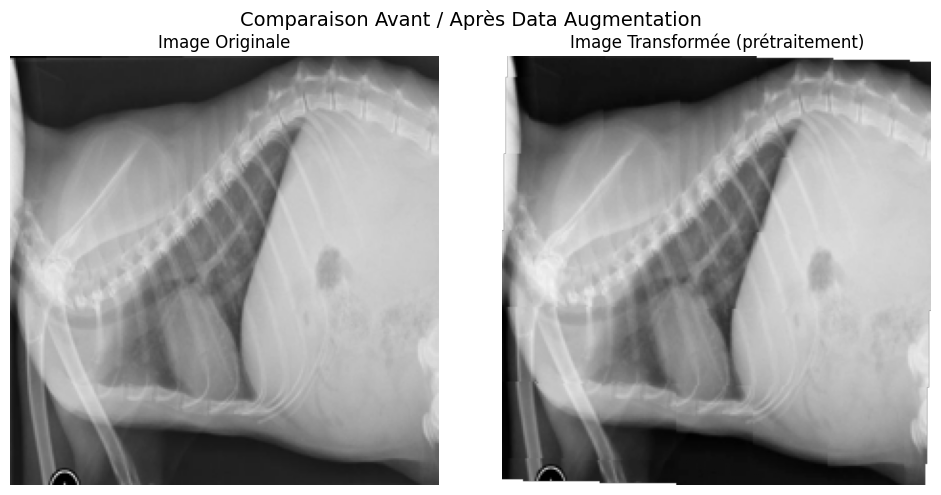

In [13]:
# %% [Affichage comparaison image originale vs transformée proprement]

import matplotlib.pyplot as plt
import torchvision.transforms.functional as TF

# Image brute Hugging Face
original_image = hf_dataset[0]["image"]

# Transformation douce pour visualisation (sans déformation extrême)
soft_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(degrees=10),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.ToTensor()
])

# Appliquer transformation
transformed_image = soft_transform(original_image)

# Convertir pour affichage matplotlib
original_np = np.array(original_image.resize((224, 224)))  # 🔁 Resize pour homogénéité visuelle
transformed_np = transformed_image.permute(1, 2, 0).numpy()

# Affichage
fig, axs = plt.subplots(1, 2, figsize=(10, 5))

axs[0].imshow(original_np)
axs[0].set_title("Image Originale", fontsize=12)
axs[0].axis('off')

axs[1].imshow(transformed_np)
axs[1].set_title("Image Transformée (prétraitement)", fontsize=12)
axs[1].axis('off')

plt.suptitle("Comparaison Avant / Après Data Augmentation", fontsize=14)
plt.tight_layout()
plt.show()

In [14]:
# Vérifier la répartition des classes après Data Augmentation
from collections import Counter

# Fonction pour compter les labels dans un DataLoader
def count_classes_in_loader(dataloader):
    total_labels = []
    for images, labels in dataloader:
        total_labels.extend(labels.cpu().numpy())
    return Counter(total_labels)

# Compter pour le train_loader
train_class_distribution = count_classes_in_loader(train_loader)

# Afficher proprement
print("📊 Répartition des classes dans le train_loader après Data Augmentation :")
for label, count in sorted(train_class_distribution.items()):
    print(f"Classe {label} : {count} images")

📊 Répartition des classes dans le train_loader après Data Augmentation :
Classe 0 : 107 images
Classe 1 : 83 images
Classe 2 : 90 images


In [15]:
def plot_learning_curves(train_losses, val_losses, train_accs, val_accs, model_name):
    """
    Affiche les courbes Loss et Accuracy pour l'entraînement/validation.
    """
    plt.figure(figsize=(14, 6))

    colors = {
        "train_loss": "#FFB347",  
        "val_loss": "#87CEFA",    
        "train_acc": "#90EE90",   
        "val_acc": "#FFB6C1"      
    }

    best_epoch = np.argmax(val_accs)
    best_val_acc = val_accs[best_epoch]
    best_val_loss = val_losses[best_epoch]

    # Courbe de Loss
    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label="Train Loss", marker='o', linewidth=2, color=colors["train_loss"])
    plt.plot(val_losses, label="Val Loss", marker='o', linewidth=2, color=colors["val_loss"])
    plt.scatter(best_epoch, best_val_loss, color='red', label=f'Best Val Loss (Epoch {best_epoch+1})', s=100, marker='*')
    plt.title(f"Évolution de la Loss — {model_name.upper()}", fontsize=16)
    plt.xlabel("Époques", fontsize=14)
    plt.ylabel("Loss", fontsize=14)
    plt.legend(fontsize=12)
    plt.grid(True, linestyle='--', alpha=0.5)

    # Courbe d'Accuracy
    plt.subplot(1, 2, 2)
    plt.plot(train_accs, label="Train Accuracy", marker='o', linewidth=2, color=colors["train_acc"])
    plt.plot(val_accs, label="Val Accuracy", marker='o', linewidth=2, color=colors["val_acc"])
    plt.scatter(best_epoch, best_val_acc, color='red', label=f'Best Val Acc (Epoch {best_epoch+1})', s=100, marker='*')
    plt.title(f"Évolution de l'Accuracy — {model_name.upper()}", fontsize=16)
    plt.xlabel("Époques", fontsize=14)
    plt.ylabel("Accuracy", fontsize=14)
    plt.legend(fontsize=12)
    plt.grid(True, linestyle='--', alpha=0.5)

    plt.suptitle(f"Courbes d'apprentissage — {model_name.upper()}", fontsize=20)
    plt.tight_layout()
    plt.show()

In [16]:
def plot_confusion_matrix(model, dataloader, class_names, model_name, device):
    """
    Affiche la matrice de confusion pour un modèle donné.
    """
    y_true, y_pred = [], []

    model.eval()
    with torch.no_grad():
        for images, labels in dataloader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            preds = outputs.argmax(dim=1)
            y_true.extend(labels.cpu().numpy())
            y_pred.extend(preds.cpu().numpy())

    cm = confusion_matrix(y_true, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)

    fig, ax = plt.subplots(figsize=(6, 6))
    disp.plot(ax=ax, cmap='Blues', values_format='d')
    plt.title(f"Matrice de confusion — {model_name.upper()}", fontsize=18)
    plt.tight_layout()
    plt.show()
    return y_true, y_pred

In [17]:
from sklearn.metrics import classification_report

def print_classification_report(y_true, y_pred, target_names=["Sain", "Réduction", "Grave"], model_name=""):
    """
    Affiche le rapport de classification (precision, recall, f1-score) pour un modèle donné.
    """
    print(f"\n📋 Rapport de classification — {model_name.upper()} :\n")
    print(classification_report(y_true, y_pred, target_names=target_names))

In [18]:
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
import numpy as np

def plot_multiclass_roc(model, val_loader, chosen_model_name, device):
    """
    Affiche les courbes ROC multiclasses pour un modèle donné.
    """
    y_true, y_score = [], []

    model.eval()
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            probs = F.softmax(outputs, dim=1)  # Probabilités par classe
            y_score.extend(probs.cpu().numpy())
            y_true.extend(labels.cpu().numpy())

    # Binariser les labels (pour ROC multiclasses)
    y_true_bin = label_binarize(y_true, classes=[0, 1, 2])

    # Calcul FPR, TPR, AUC pour chaque classe
    fpr, tpr, roc_auc = {}, {}, {}
    n_classes = 3
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_true_bin[:, i], np.array(y_score)[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # Affichage
    plt.figure(figsize=(8, 6))
    colors = ['green', 'orange', 'red']
    labels_text = ["Sain", "Réduction", "Grave"]

    for i in range(n_classes):
        plt.plot(fpr[i], tpr[i], color=colors[i], lw=2,
                    label=f"{labels_text[i]} (AUC = {roc_auc[i]:.2f})")

    plt.plot([0, 1], [0, 1], 'k--', lw=1)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel("Taux de Faux Positifs (FPR)", fontsize=12)
    plt.ylabel("Taux de Vrais Positifs (TPR)", fontsize=12)
    plt.title(f"🌈 Courbes ROC — {chosen_model_name.upper()}", fontsize=14)
    plt.legend(loc="lower right", fontsize=11)
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()

In [19]:
#Bloc 7 — Définir plusieurs modèles Deep Learning

from torchvision.models import (
    resnet18, resnet34,
    densenet121,
    efficientnet_b0,
    vit_b_16,
    convnext_base
)
from torchvision.models import ViT_B_16_Weights, ConvNeXt_Base_Weights

def build_model(model_name):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")  # ✅ Ajout ici
    if model_name == "resnet18":
        model = models.resnet18(pretrained=True)
        num_features = model.fc.in_features
        model.fc = nn.Linear(num_features, 3)

    elif model_name == "resnet34":
        model = models.resnet34(pretrained=True)
        num_features = model.fc.in_features
        model.fc = nn.Linear(num_features, 3)

    elif model_name == "densenet121":
        model = models.densenet121(pretrained=True)
        num_features = model.classifier.in_features
        model.classifier = nn.Linear(num_features, 3)

    elif model_name == "efficientnet_b0":
        model = models.efficientnet_b0(pretrained=True)
        num_features = model.classifier[1].in_features
        model.classifier[1] = nn.Linear(num_features, 3)

    elif model_name == "vit_b_16":
        weights = ViT_B_16_Weights.DEFAULT
        model = vit_b_16(weights=weights)
        num_features = model.heads.head.in_features
        model.heads.head = nn.Linear(num_features, 3)

    elif model_name == "convnext_base":
        weights = ConvNeXt_Base_Weights.DEFAULT
        model = convnext_base(weights=weights)
        num_features = model.classifier[2].in_features
        model.classifier[2] = nn.Linear(num_features, 3)
        
    else:
        raise ValueError(f"Modèle {model_name} non supporté !")

    return model.to(device)

# Liste des modèles à tester
model_names = ["resnet18", "resnet34", "densenet121", "efficientnet_b0", "vit_b_16", "convnext_base"]

print(f"✅ Fonction build_model prête pour {model_names}")


✅ Fonction build_model prête pour ['resnet18', 'resnet34', 'densenet121', 'efficientnet_b0', 'vit_b_16', 'convnext_base']


In [20]:
# Initialisation du dictionnaire global des performances
model_performances = {}

In [21]:
def train_and_evaluate(model, model_name, train_loader, val_loader, num_epochs=10, patience=5, lr=0.0005):
    """
    Entraîne un modèle et retourne les courbes d’apprentissage et les performances.
    """
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = model.to(device)

    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)

    train_losses, val_losses = [], []
    train_accs, val_accs = [], []

    best_val_loss = float('inf')
    counter = 0

    print(f"🚀 Entraînement du modèle {model_name.upper()}...\n")

    for epoch in range(num_epochs):
        model.train()
        running_loss, correct, total = 0.0, 0, 0

        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)

        train_loss = running_loss / len(train_loader)
        train_acc = correct / total
        train_losses.append(train_loss)
        train_accs.append(train_acc)

        # Validation
        model.eval()
        val_loss, correct, total = 0.0, 0, 0
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)

                val_loss += loss.item()
                _, predicted = torch.max(outputs, 1)
                correct += (predicted == labels).sum().item()
                total += labels.size(0)

        val_loss /= len(val_loader)
        val_acc = correct / total
        val_losses.append(val_loss)
        val_accs.append(val_acc)

        print(f"📈 Époch {epoch+1}/{num_epochs} — Train Acc: {train_acc:.4f} | Val Acc: {val_acc:.4f}")

        # Early stopping
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            counter = 0
        else:
            counter += 1
            print(f"⚠️ Patience : {counter}/{patience}")
            if counter >= patience:
                print(f"⛔ Early stopping activé à l'époque {epoch+1} !")
                break

    print("✅ Entraînement terminé !")
    
    # 🔄 Mise à jour automatique des performances
    model_performances[model_name.upper()] = {
        "best_val_acc": max(val_accs),
        "best_val_loss": min(val_losses)
    }
    
    return model, train_losses, val_losses, train_accs, val_accs


In [22]:
chosen_model_name = "resnet18"
model = build_model(chosen_model_name)

model, train_losses, val_losses, train_accs, val_accs = train_and_evaluate(
    model, chosen_model_name, train_loader, val_loader, num_epochs=10, patience=5, lr=0.0005
)
print(f"🔥 Best Val Accuracy for {chosen_model_name.upper()} = {max(val_accs):.4f}")

c:\Users\Dorra Sioud\AppData\Local\Programs\Python\Python312\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Dorra Sioud\AppData\Local\Programs\Python\Python312\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


🚀 Entraînement du modèle RESNET18...

📈 Époch 1/10 — Train Acc: 0.7071 | Val Acc: 0.8143
📈 Époch 2/10 — Train Acc: 0.7500 | Val Acc: 0.7429
⚠️ Patience : 1/5
📈 Époch 3/10 — Train Acc: 0.7429 | Val Acc: 0.8000
⚠️ Patience : 2/5
📈 Époch 4/10 — Train Acc: 0.7893 | Val Acc: 0.6857
⚠️ Patience : 3/5
📈 Époch 5/10 — Train Acc: 0.7893 | Val Acc: 0.7714
⚠️ Patience : 4/5
📈 Époch 6/10 — Train Acc: 0.7964 | Val Acc: 0.3571
⚠️ Patience : 5/5
⛔ Early stopping activé à l'époque 6 !
✅ Entraînement terminé !
🔥 Best Val Accuracy for RESNET18 = 0.8143


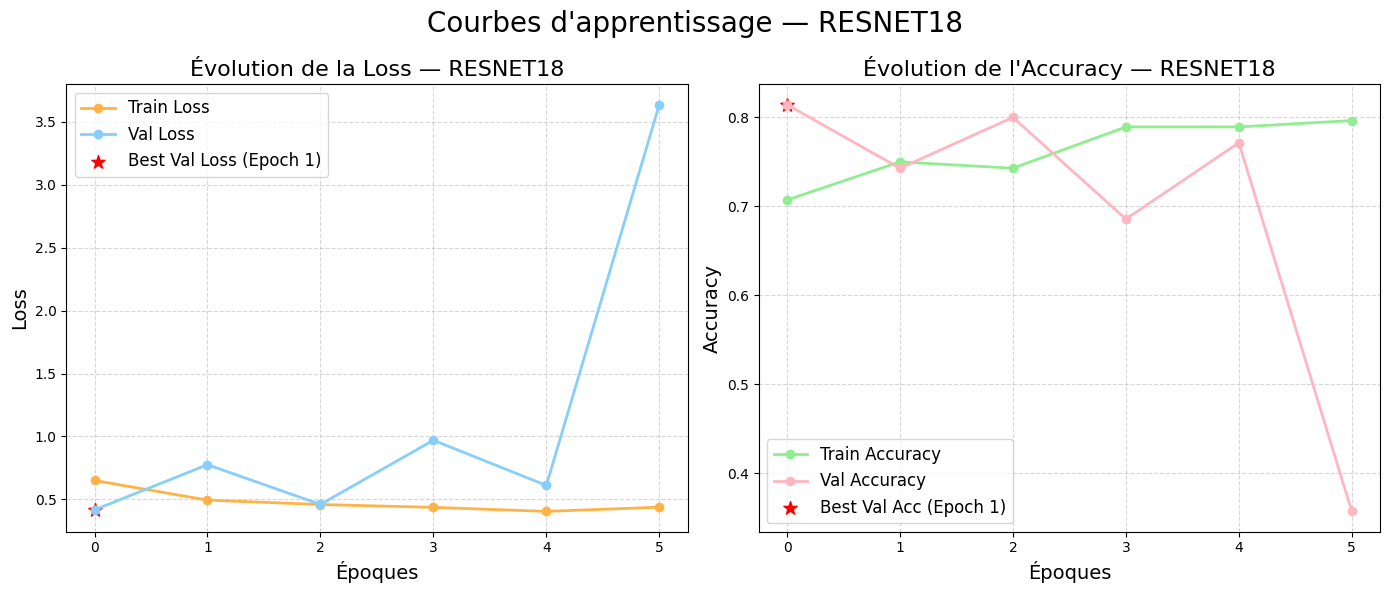

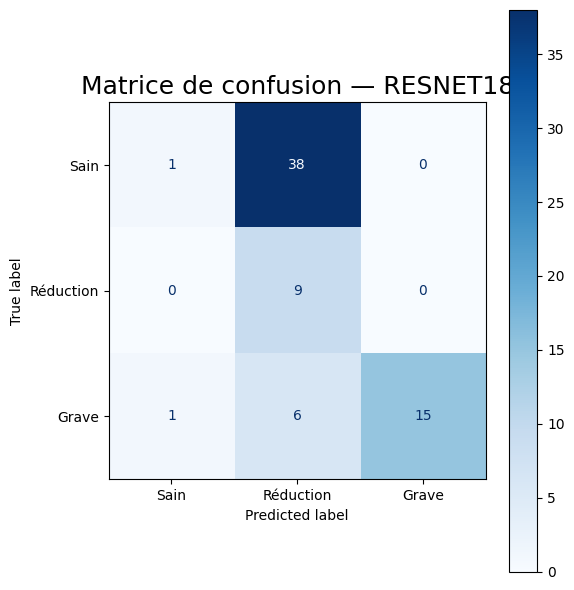

In [23]:
plot_learning_curves(train_losses, val_losses, train_accs, val_accs, chosen_model_name)
y_true, y_pred = plot_confusion_matrix(model, val_loader, ["Sain", "Réduction", "Grave"], chosen_model_name, device)

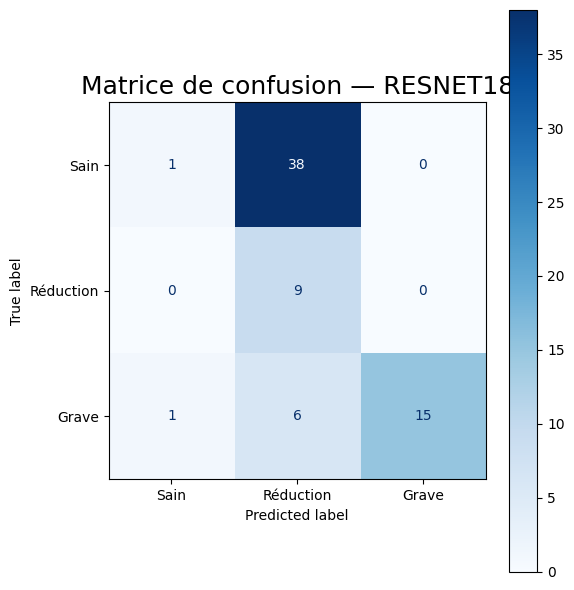


📋 Rapport de classification — RESNET18 :

              precision    recall  f1-score   support

        Sain       0.50      0.03      0.05        39
   Réduction       0.17      1.00      0.29         9
       Grave       1.00      0.68      0.81        22

    accuracy                           0.36        70
   macro avg       0.56      0.57      0.38        70
weighted avg       0.61      0.36      0.32        70



In [24]:
y_true, y_pred = plot_confusion_matrix(
    model, val_loader, ["Sain", "Réduction", "Grave"], chosen_model_name, device
)
print_classification_report(y_true, y_pred, model_name=chosen_model_name)

C:\Users\Dorra Sioud\AppData\Local\Temp\ipykernel_23792\840819653.py:48: UserWarning: Glyph 127752 (\N{RAINBOW}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
c:\Users\Dorra Sioud\AppData\Local\Programs\Python\Python312\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 127752 (\N{RAINBOW}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


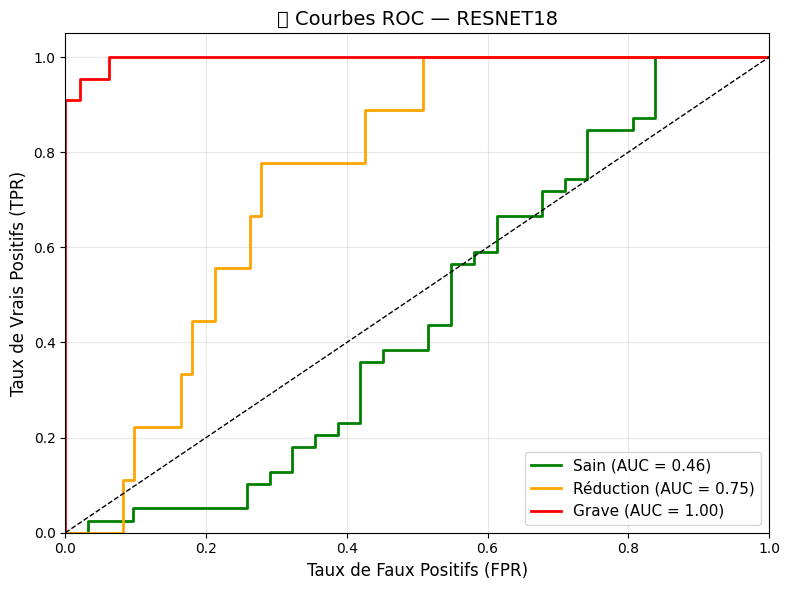

In [25]:
plot_multiclass_roc(model, val_loader, chosen_model_name, device)

In [26]:
# Bloc 10 — Charger ResNet34

chosen_model_name = "resnet34"
model = build_model(chosen_model_name)
model, train_losses, val_losses, train_accs, val_accs = train_and_evaluate(
    model, chosen_model_name, train_loader, val_loader, num_epochs=10, patience=5, lr=0.0005
)
print(f"🔥 Best Val Accuracy for {chosen_model_name.upper()} = {max(val_accs):.4f}")

c:\Users\Dorra Sioud\AppData\Local\Programs\Python\Python312\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Dorra Sioud\AppData\Local\Programs\Python\Python312\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet34_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


🚀 Entraînement du modèle RESNET34...

📈 Époch 1/10 — Train Acc: 0.6357 | Val Acc: 0.4857
📈 Époch 2/10 — Train Acc: 0.6643 | Val Acc: 0.4429
📈 Époch 3/10 — Train Acc: 0.6464 | Val Acc: 0.7857
📈 Époch 4/10 — Train Acc: 0.6821 | Val Acc: 0.5429
⚠️ Patience : 1/5
📈 Époch 5/10 — Train Acc: 0.7357 | Val Acc: 0.5286
⚠️ Patience : 2/5
📈 Époch 6/10 — Train Acc: 0.7857 | Val Acc: 0.7143
📈 Époch 7/10 — Train Acc: 0.7714 | Val Acc: 0.6857
⚠️ Patience : 1/5
📈 Époch 8/10 — Train Acc: 0.8393 | Val Acc: 0.8000
📈 Époch 9/10 — Train Acc: 0.8179 | Val Acc: 0.7429
⚠️ Patience : 1/5
📈 Époch 10/10 — Train Acc: 0.8500 | Val Acc: 0.4571
⚠️ Patience : 2/5
✅ Entraînement terminé !
🔥 Best Val Accuracy for RESNET34 = 0.8000


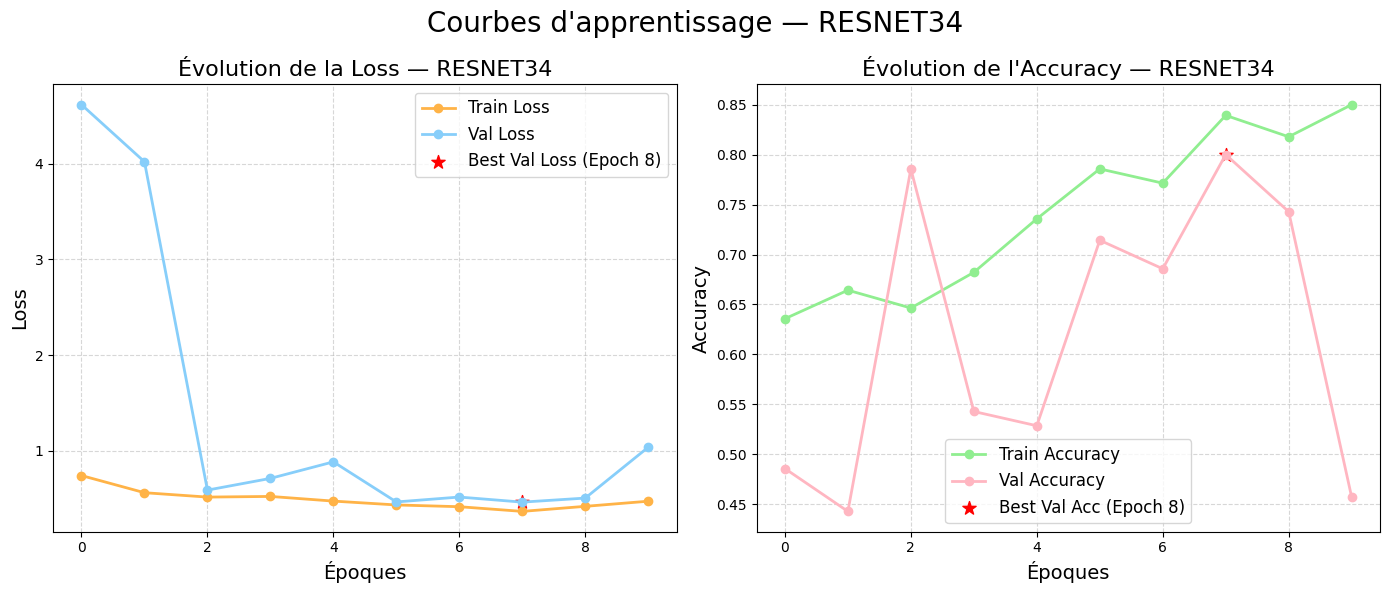

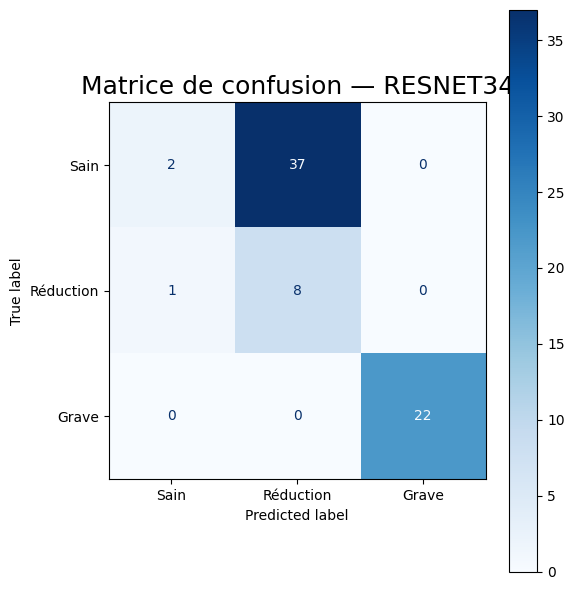


📋 Rapport de classification —  :

              precision    recall  f1-score   support

        Sain       0.67      0.05      0.10        39
   Réduction       0.18      0.89      0.30         9
       Grave       1.00      1.00      1.00        22

    accuracy                           0.46        70
   macro avg       0.61      0.65      0.46        70
weighted avg       0.71      0.46      0.41        70



In [27]:
plot_learning_curves(train_losses, val_losses, train_accs, val_accs, chosen_model_name)
y_true, y_pred = plot_confusion_matrix(model, val_loader, ["Sain", "Réduction", "Grave"], chosen_model_name, device)
print_classification_report(y_true, y_pred)

C:\Users\Dorra Sioud\AppData\Local\Temp\ipykernel_23792\840819653.py:48: UserWarning: Glyph 127752 (\N{RAINBOW}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
c:\Users\Dorra Sioud\AppData\Local\Programs\Python\Python312\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 127752 (\N{RAINBOW}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


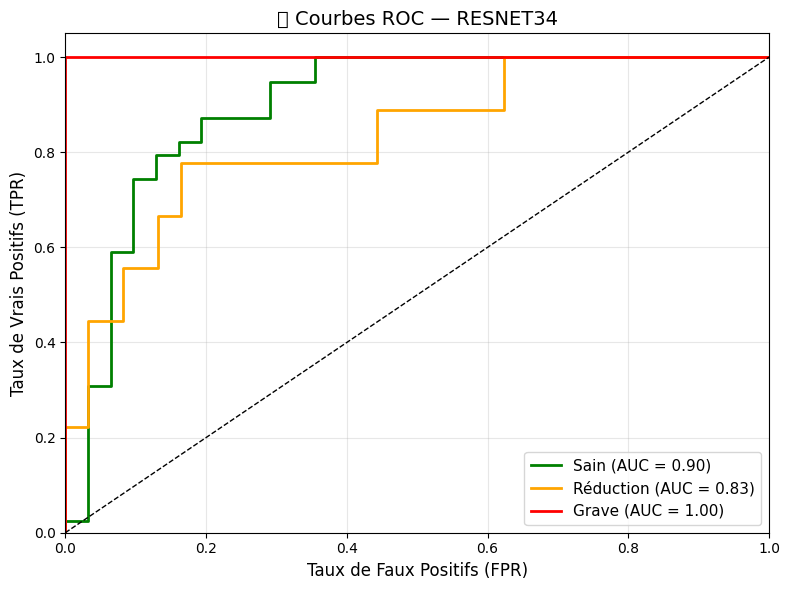

In [28]:
plot_multiclass_roc(model, val_loader, chosen_model_name, device)

c:\Users\Dorra Sioud\AppData\Local\Programs\Python\Python312\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Dorra Sioud\AppData\Local\Programs\Python\Python312\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DenseNet121_Weights.IMAGENET1K_V1`. You can also use `weights=DenseNet121_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


🚀 Entraînement du modèle DENSENET121...

📈 Époch 1/10 — Train Acc: 0.7286 | Val Acc: 0.8286
📈 Époch 2/10 — Train Acc: 0.7036 | Val Acc: 0.2714
⚠️ Patience : 1/5
📈 Époch 3/10 — Train Acc: 0.8000 | Val Acc: 0.5143
⚠️ Patience : 2/5
📈 Époch 4/10 — Train Acc: 0.8500 | Val Acc: 0.8429
📈 Époch 5/10 — Train Acc: 0.8571 | Val Acc: 0.7286
⚠️ Patience : 1/5
📈 Époch 6/10 — Train Acc: 0.8464 | Val Acc: 0.6714
⚠️ Patience : 2/5
📈 Époch 7/10 — Train Acc: 0.8643 | Val Acc: 0.8571
⚠️ Patience : 3/5
📈 Époch 8/10 — Train Acc: 0.8857 | Val Acc: 0.8286
⚠️ Patience : 4/5
📈 Époch 9/10 — Train Acc: 0.8929 | Val Acc: 0.7286
⚠️ Patience : 5/5
⛔ Early stopping activé à l'époque 9 !
✅ Entraînement terminé !
🔥 Best Val Accuracy for DENSENET121 = 0.8571


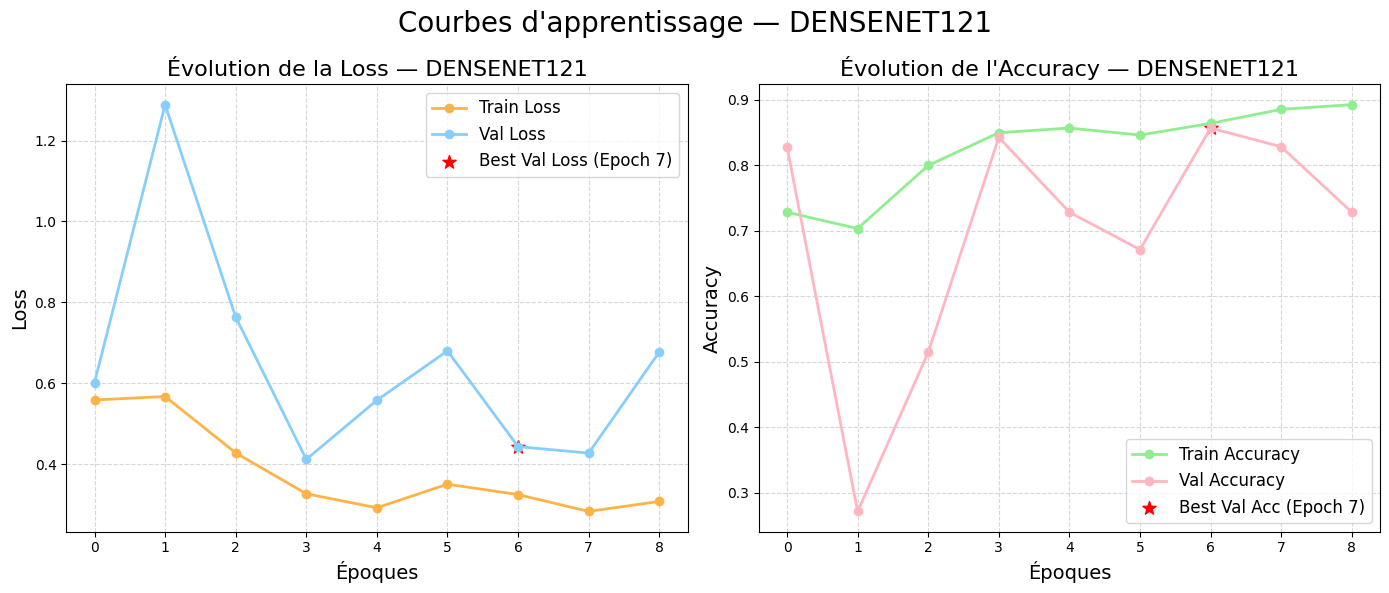

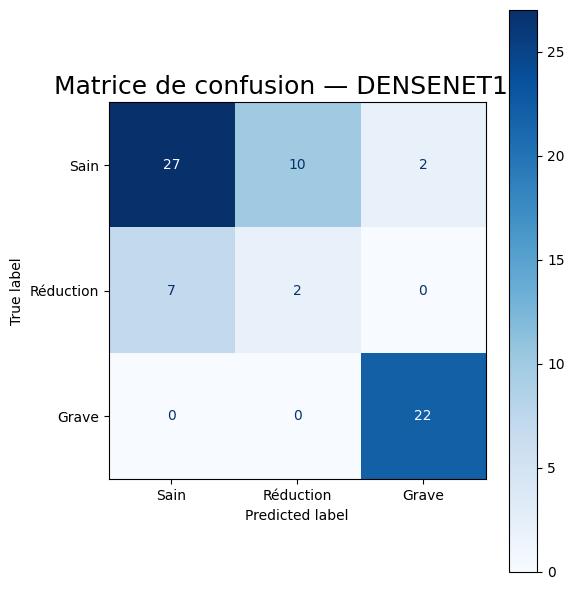


📋 Rapport de classification — DENSENET121 :

              precision    recall  f1-score   support

        Sain       0.79      0.69      0.74        39
   Réduction       0.17      0.22      0.19         9
       Grave       0.92      1.00      0.96        22

    accuracy                           0.73        70
   macro avg       0.63      0.64      0.63        70
weighted avg       0.75      0.73      0.74        70



C:\Users\Dorra Sioud\AppData\Local\Temp\ipykernel_23792\840819653.py:48: UserWarning: Glyph 127752 (\N{RAINBOW}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
c:\Users\Dorra Sioud\AppData\Local\Programs\Python\Python312\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 127752 (\N{RAINBOW}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


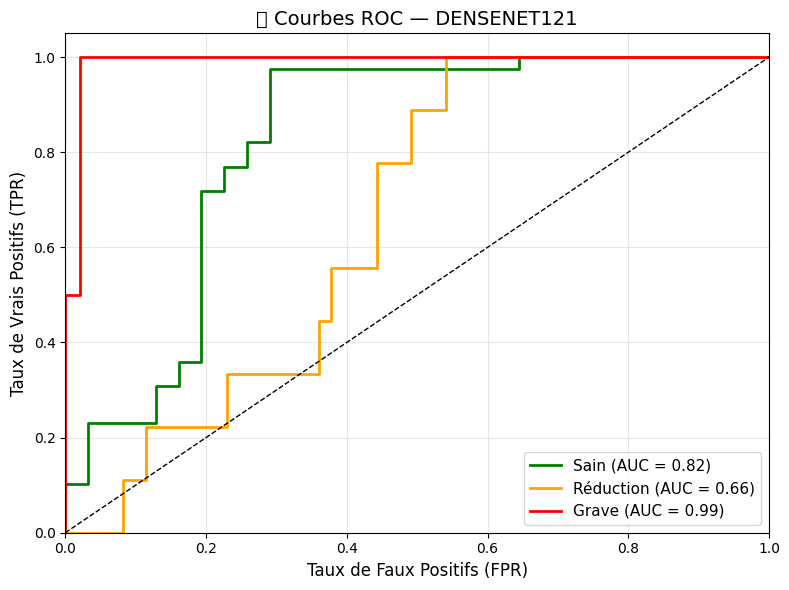

In [29]:
# 📌 Modèle DenseNet121
chosen_model_name = "densenet121"
model = build_model(chosen_model_name)

# ✅ Entraînement et évaluation
model, train_losses, val_losses, train_accs, val_accs = train_and_evaluate(
    model, chosen_model_name, train_loader, val_loader, num_epochs=10, patience=5, lr=0.0005
)

# 🔥 Affichage des meilleures performances
print(f"🔥 Best Val Accuracy for {chosen_model_name.upper()} = {max(val_accs):.4f}")

# 📈 Courbes d'apprentissage
plot_learning_curves(train_losses, val_losses, train_accs, val_accs, chosen_model_name)

# 📊 Matrice de confusion
y_true, y_pred = plot_confusion_matrix(model, val_loader, ["Sain", "Réduction", "Grave"], chosen_model_name, device)

# 📋 Rapport de classification
print_classification_report(y_true, y_pred, model_name=chosen_model_name)

# 🌈 Courbes ROC
plot_multiclass_roc(model, val_loader, chosen_model_name, device)

c:\Users\Dorra Sioud\AppData\Local\Programs\Python\Python312\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Dorra Sioud\AppData\Local\Programs\Python\Python312\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B0_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B0_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


🚀 Entraînement du modèle EFFICIENTNET_B0...

📈 Époch 1/10 — Train Acc: 0.6214 | Val Acc: 0.7000
📈 Époch 2/10 — Train Acc: 0.8107 | Val Acc: 0.6429
📈 Époch 3/10 — Train Acc: 0.7786 | Val Acc: 0.8571
📈 Époch 4/10 — Train Acc: 0.8536 | Val Acc: 0.8714
⚠️ Patience : 1/5
📈 Époch 5/10 — Train Acc: 0.8964 | Val Acc: 0.5143
⚠️ Patience : 2/5
📈 Époch 6/10 — Train Acc: 0.8857 | Val Acc: 0.7429
⚠️ Patience : 3/5
📈 Époch 7/10 — Train Acc: 0.8893 | Val Acc: 0.7143
⚠️ Patience : 4/5
📈 Époch 8/10 — Train Acc: 0.9464 | Val Acc: 0.8429
⚠️ Patience : 5/5
⛔ Early stopping activé à l'époque 8 !
✅ Entraînement terminé !
🔥 Best Val Accuracy for EFFICIENTNET_B0 = 0.8714


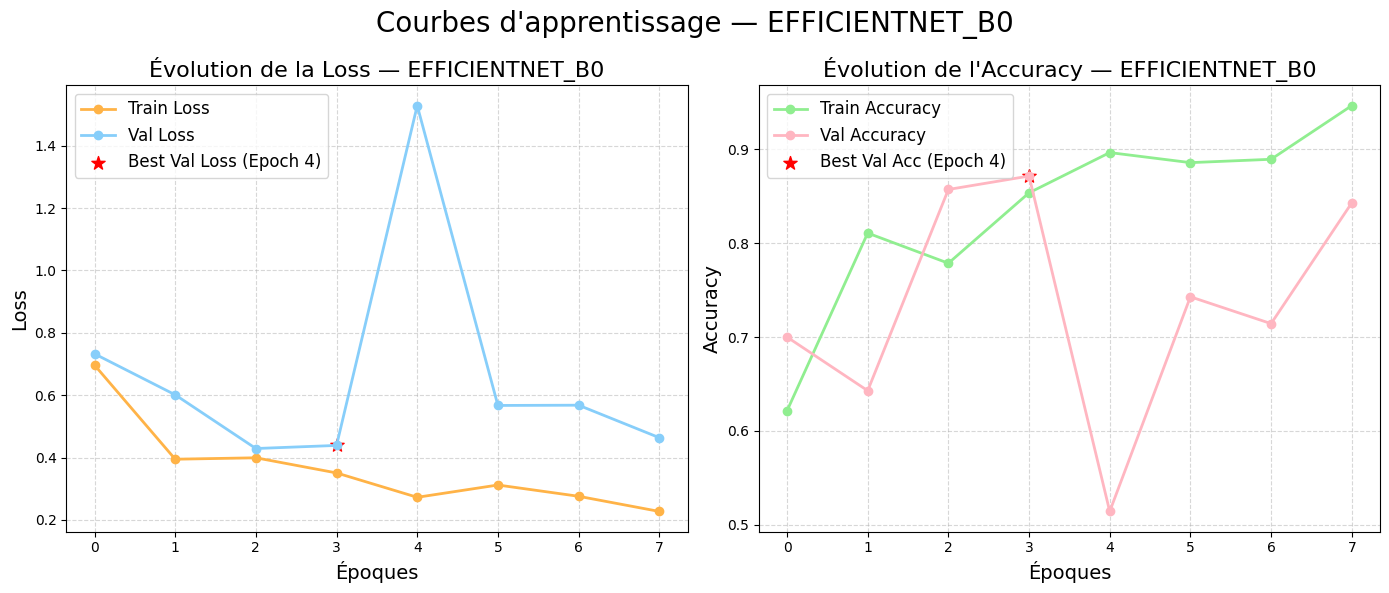

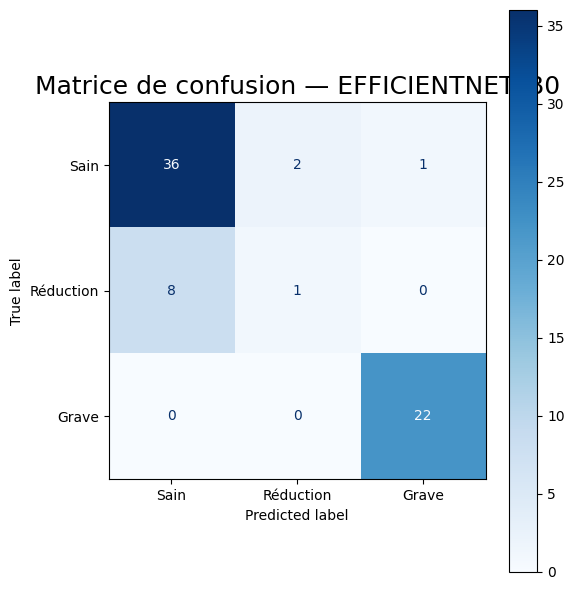


📋 Rapport de classification — EFFICIENTNET_B0 :

              precision    recall  f1-score   support

        Sain       0.82      0.92      0.87        39
   Réduction       0.33      0.11      0.17         9
       Grave       0.96      1.00      0.98        22

    accuracy                           0.84        70
   macro avg       0.70      0.68      0.67        70
weighted avg       0.80      0.84      0.81        70



C:\Users\Dorra Sioud\AppData\Local\Temp\ipykernel_23792\840819653.py:48: UserWarning: Glyph 127752 (\N{RAINBOW}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
c:\Users\Dorra Sioud\AppData\Local\Programs\Python\Python312\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 127752 (\N{RAINBOW}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


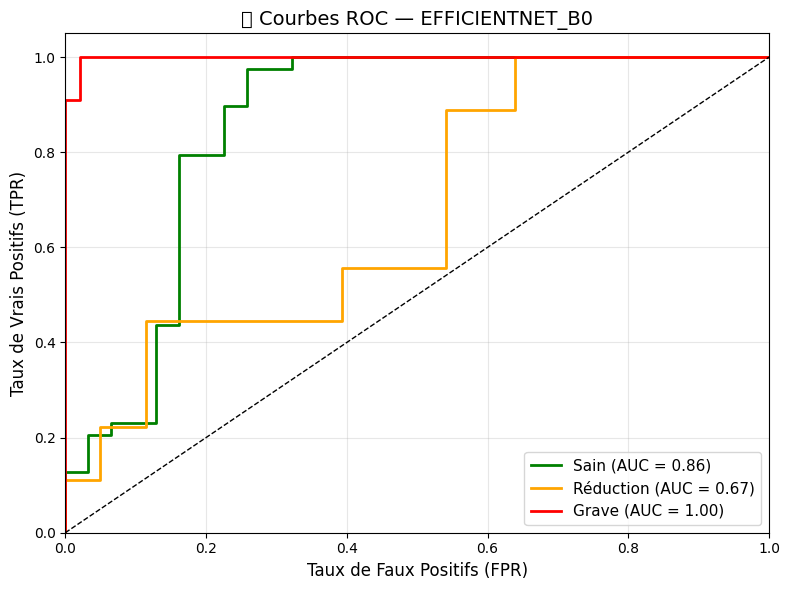

In [30]:
# Bloc 13 — Charger et entraîner EfficientNet-B0

chosen_model_name = "efficientnet_b0"
model = build_model(chosen_model_name)

# ✅ Entraînement complet
model, train_losses, val_losses, train_accs, val_accs = train_and_evaluate(
    model, chosen_model_name, train_loader, val_loader,
    num_epochs=10, patience=5, lr=0.0005
)

# 🔥 Résumé performance
print(f"🔥 Best Val Accuracy for {chosen_model_name.upper()} = {max(val_accs):.4f}")

# 📈 Courbes d'apprentissage
plot_learning_curves(train_losses, val_losses, train_accs, val_accs, chosen_model_name)

# 📊 Matrice de confusion
y_true, y_pred = plot_confusion_matrix(model, val_loader, ["Sain", "Réduction", "Grave"], chosen_model_name, device)

# 📋 Rapport de classification
print_classification_report(y_true, y_pred, model_name=chosen_model_name)

# 🌈 Courbes ROC
plot_multiclass_roc(model, val_loader, chosen_model_name, device)

🚀 Entraînement du modèle VIT_B_16...

📈 Époch 1/10 — Train Acc: 0.3286 | Val Acc: 0.3571
📈 Époch 2/10 — Train Acc: 0.4821 | Val Acc: 0.3143
⚠️ Patience : 1/5
📈 Époch 3/10 — Train Acc: 0.4536 | Val Acc: 0.6857
📈 Époch 4/10 — Train Acc: 0.5393 | Val Acc: 0.4000
⚠️ Patience : 1/5
📈 Époch 5/10 — Train Acc: 0.5643 | Val Acc: 0.7143
📈 Époch 6/10 — Train Acc: 0.5893 | Val Acc: 0.5714
⚠️ Patience : 1/5
📈 Époch 7/10 — Train Acc: 0.5679 | Val Acc: 0.4000
⚠️ Patience : 2/5
📈 Époch 8/10 — Train Acc: 0.4821 | Val Acc: 0.3571
⚠️ Patience : 3/5
📈 Époch 9/10 — Train Acc: 0.5464 | Val Acc: 0.4286
⚠️ Patience : 4/5
📈 Époch 10/10 — Train Acc: 0.5786 | Val Acc: 0.6429
⚠️ Patience : 5/5
⛔ Early stopping activé à l'époque 10 !
✅ Entraînement terminé !


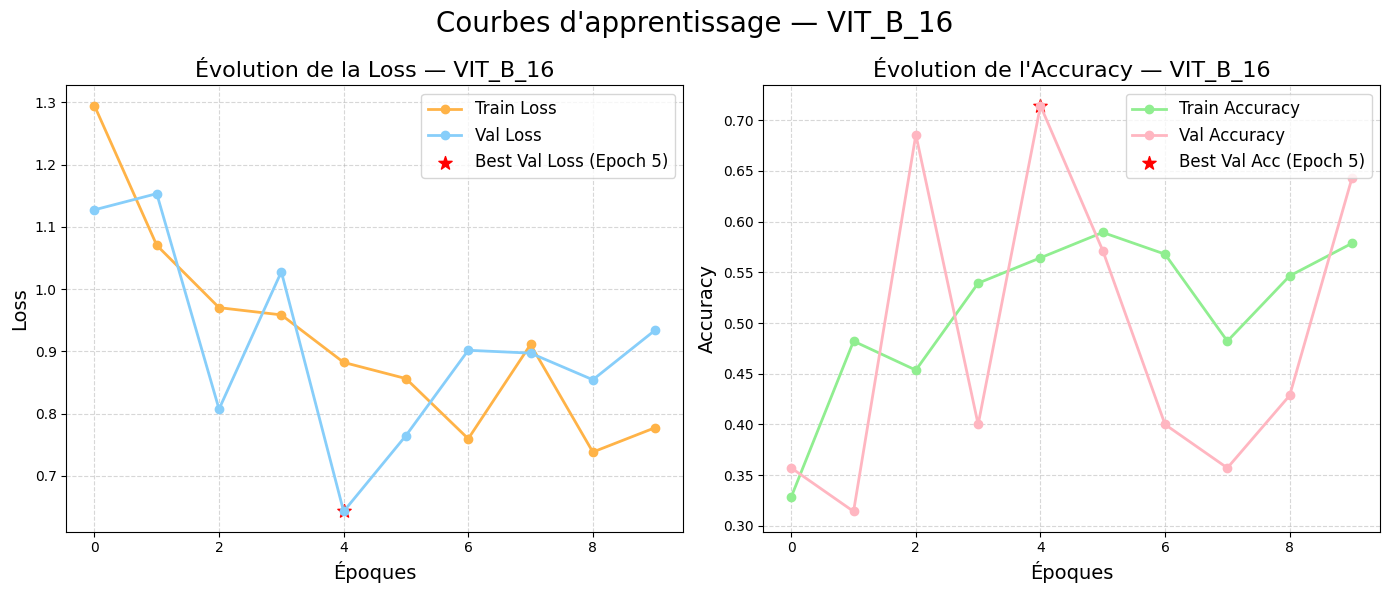

TypeError: plot_confusion_matrix() missing 2 required positional arguments: 'model_name' and 'device'

In [ ]:
# 📌 Modèle Vision Transformer (ViT)
chosen_model_name = "vit_b_16"
model = build_model(chosen_model_name)

# 🔁 Entraînement
model, train_losses, val_losses, train_accs, val_accs = train_and_evaluate(
    model, chosen_model_name, train_loader, val_loader
)

In [32]:
# 🔥 Résumé performance
print(f"🔥 Best Val Accuracy for {chosen_model_name.upper()} = {max(val_accs):.4f}")

🔥 Best Val Accuracy for VIT_B_16 = 0.7143


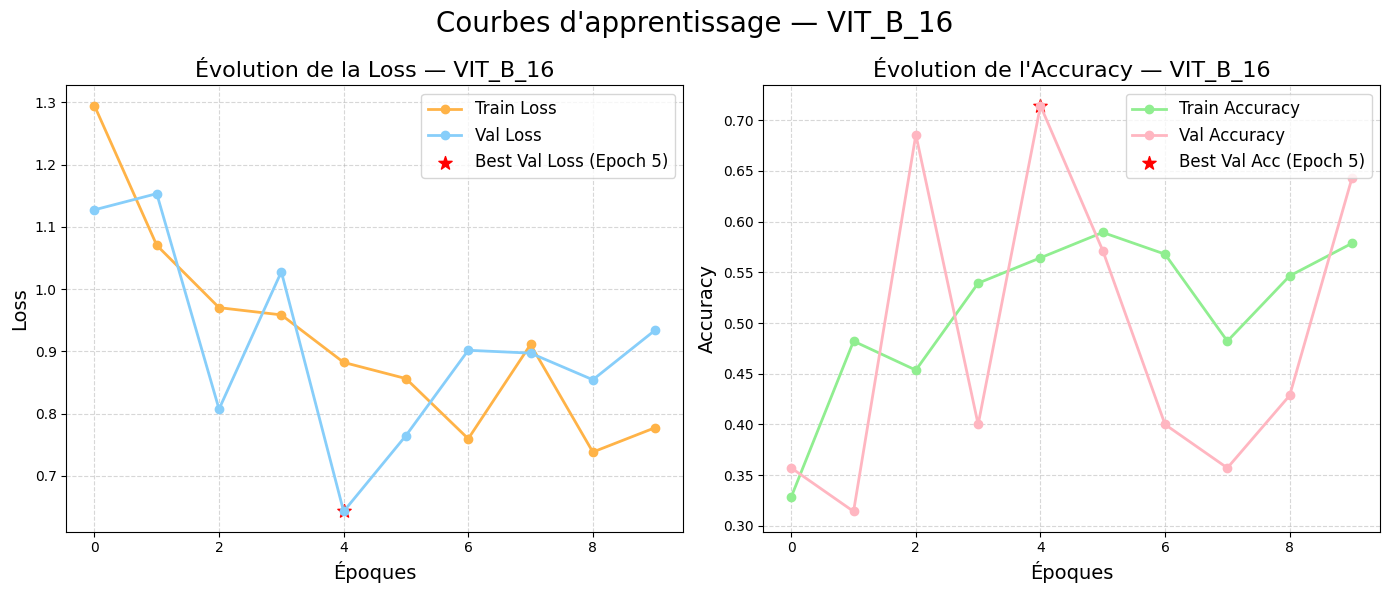

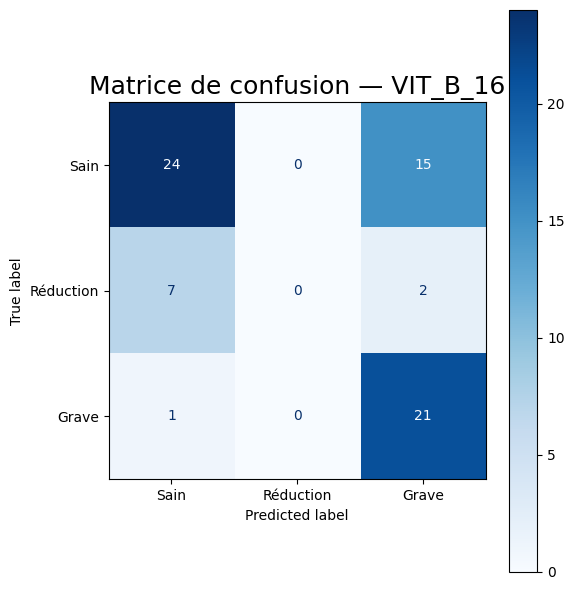


📋 Rapport de classification —  :

              precision    recall  f1-score   support

        Sain       0.75      0.62      0.68        39
   Réduction       0.00      0.00      0.00         9
       Grave       0.55      0.95      0.70        22

    accuracy                           0.64        70
   macro avg       0.43      0.52      0.46        70
weighted avg       0.59      0.64      0.60        70



c:\Users\Dorra Sioud\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Dorra Sioud\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Dorra Sioud\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _wa

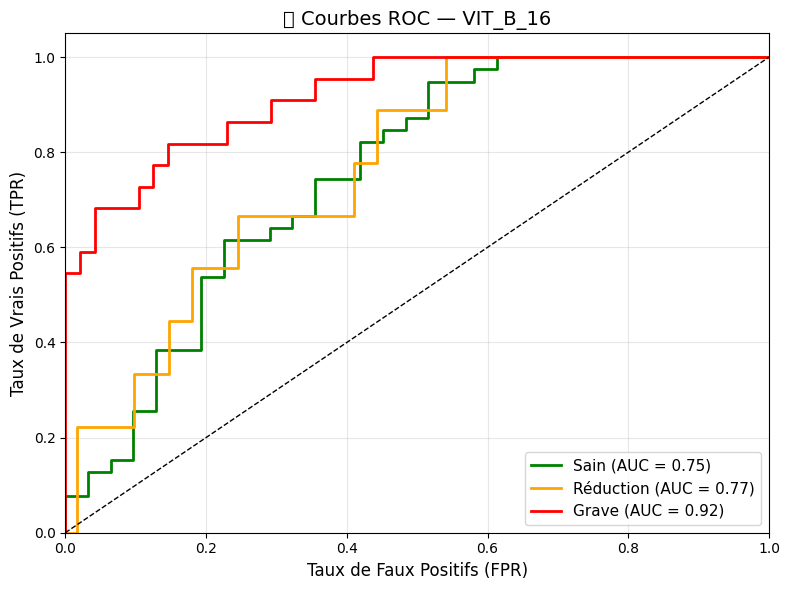

In [33]:
# 📈 Visualisation des courbes
plot_learning_curves(train_losses, val_losses, train_accs, val_accs, chosen_model_name)

# 📊 Matrice de confusion
y_true, y_pred = plot_confusion_matrix(model, val_loader, ["Sain", "Réduction", "Grave"], chosen_model_name, device)

# 📋 Rapport de classification
print_classification_report(y_true, y_pred)

# 🌈 Courbes ROC
plot_multiclass_roc(model, val_loader, chosen_model_name, device)

🚀 Entraînement du modèle CONVNEXT_BASE...

📈 Époch 1/10 — Train Acc: 0.4250 | Val Acc: 0.3714
📈 Époch 2/10 — Train Acc: 0.5500 | Val Acc: 0.4143
⚠️ Patience : 1/5
📈 Époch 3/10 — Train Acc: 0.5036 | Val Acc: 0.6000
📈 Époch 4/10 — Train Acc: 0.5500 | Val Acc: 0.4286
⚠️ Patience : 1/5
📈 Époch 5/10 — Train Acc: 0.5893 | Val Acc: 0.7143
📈 Époch 6/10 — Train Acc: 0.6143 | Val Acc: 0.8286
📈 Époch 7/10 — Train Acc: 0.6143 | Val Acc: 0.8429
📈 Époch 8/10 — Train Acc: 0.6893 | Val Acc: 0.4429
⚠️ Patience : 1/5
📈 Époch 9/10 — Train Acc: 0.6500 | Val Acc: 0.4429
⚠️ Patience : 2/5
📈 Époch 10/10 — Train Acc: 0.6500 | Val Acc: 0.5429
⚠️ Patience : 3/5
✅ Entraînement terminé !
🔥 Best Val Accuracy for CONVNEXT_BASE = 0.8429


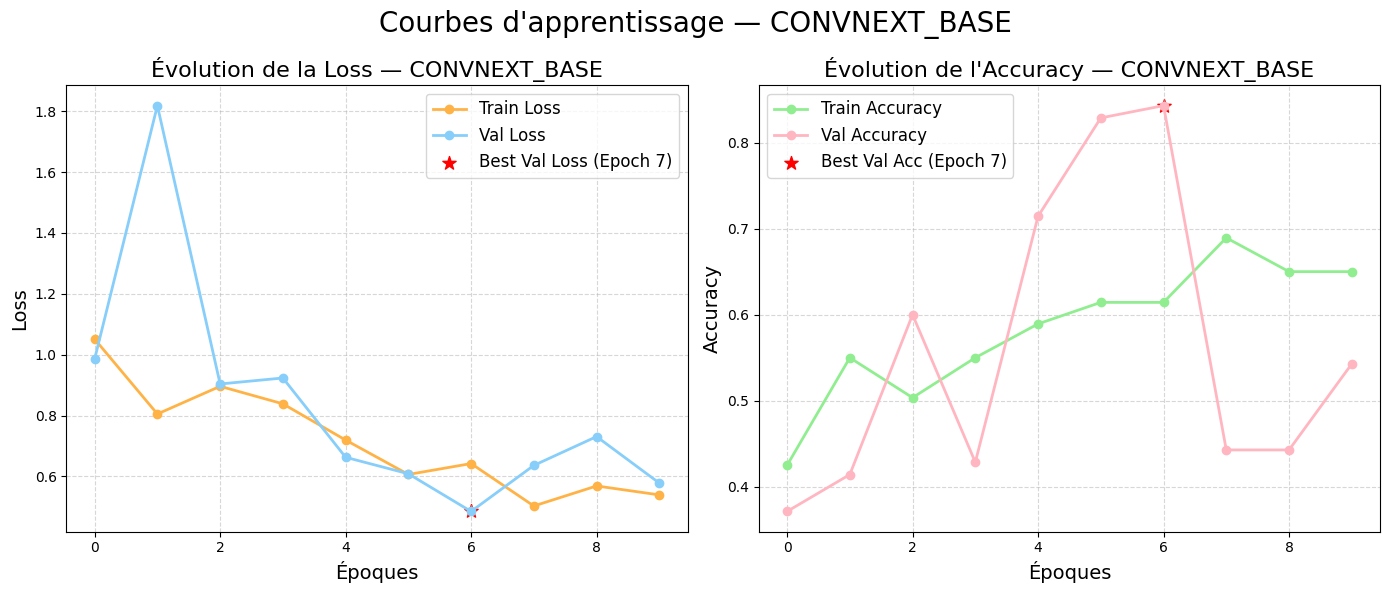

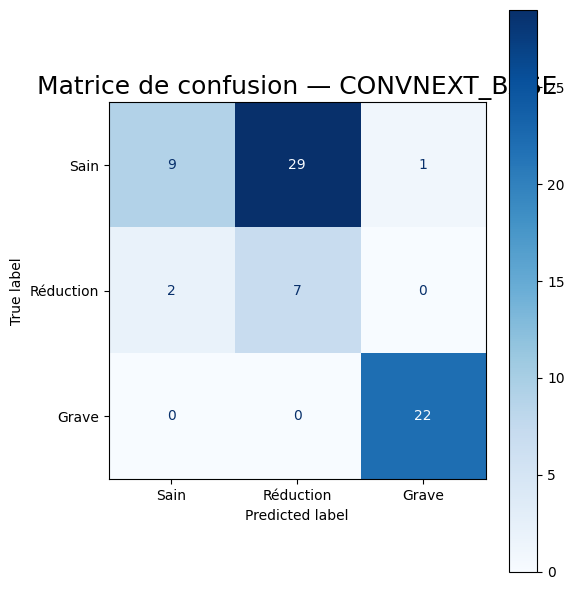


📋 Rapport de classification —  :

              precision    recall  f1-score   support

        Sain       0.82      0.23      0.36        39
   Réduction       0.19      0.78      0.31         9
       Grave       0.96      1.00      0.98        22

    accuracy                           0.54        70
   macro avg       0.66      0.67      0.55        70
weighted avg       0.78      0.54      0.55        70



TypeError: plot_multiclass_roc() missing 1 required positional argument: 'device'

In [ ]:
# 📌 Modèle ConvNeXt-Base
chosen_model_name = "convnext_base"
model = build_model(chosen_model_name)

# 🔁 Entraînement
model, train_losses, val_losses, train_accs, val_accs = train_and_evaluate(
    model, chosen_model_name, train_loader, val_loader
)

# 🔥 Résumé performance
print(f"🔥 Best Val Accuracy for {chosen_model_name.upper()} = {max(val_accs):.4f}")

# 📈 Visualisation des courbes
plot_learning_curves(train_losses, val_losses, train_accs, val_accs, chosen_model_name)

# 📊 Matrice de confusion
y_true, y_pred = plot_confusion_matrix(model, val_loader, ["Sain", "Réduction", "Grave"], chosen_model_name, device)

# 📋 Rapport de classification
print_classification_report(y_true, y_pred)

C:\Users\Dorra Sioud\AppData\Local\Temp\ipykernel_23792\840819653.py:48: UserWarning: Glyph 127752 (\N{RAINBOW}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
c:\Users\Dorra Sioud\AppData\Local\Programs\Python\Python312\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 127752 (\N{RAINBOW}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


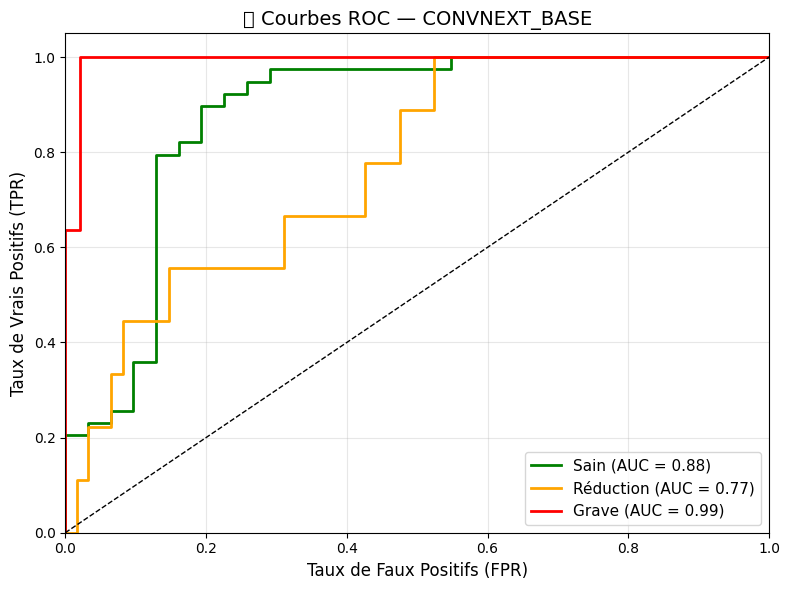

In [35]:
# 🌈 Courbes ROC
plot_multiclass_roc(model, val_loader, chosen_model_name, device)

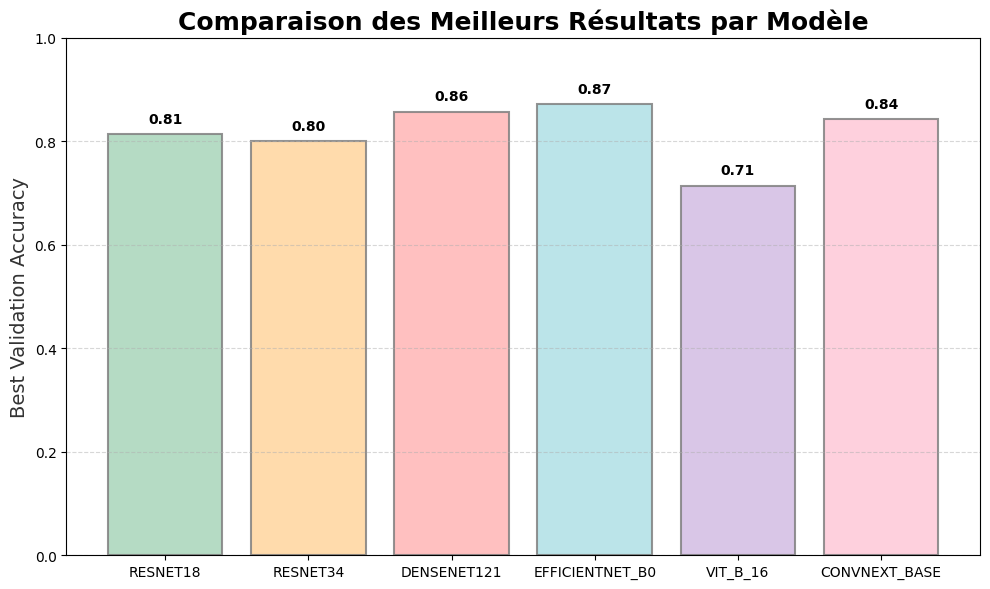

📋 Résumé comparatif des modèles :


,best_val_acc,best_val_loss
Model,,
RESNET18,0.814286,0.416066
RESNET34,0.800000,0.465804
DENSENET121,0.857143,0.411586
EFFICIENTNET_B0,0.871429,0.428897
VIT_B_16,0.714286,0.642920
CONVNEXT_BASE,0.842857,0.485072


In [37]:
# Bloc 19 — Comparaison visuelle finale dynamique (pastel & automatique)

import matplotlib.pyplot as plt
import pandas as pd

# 🔍 1. Extraire les données
models = list(model_performances.keys())
best_accs = [model_performances[m]["best_val_acc"] for m in models]
best_losses = [model_performances[m]["best_val_loss"] for m in models]

# 🎨 2. Générer dynamiquement des couleurs pastel si plus de modèles ajoutés
default_colors = ["#A8D5BA", "#FFD59E", "#FFB5B5", "#B0E0E6", "#D3BCE3", "#FEC8D8"]
while len(default_colors) < len(models):
    default_colors.append("#C2E5FF")  # fallback bleu pastel

# 📊 3. Barplot
fig, ax1 = plt.subplots(figsize=(10, 6))
bars = ax1.bar(models, best_accs, color=default_colors[:len(models)],
                alpha=0.85, edgecolor='grey', linewidth=1.5)

ax1.set_ylabel('Best Validation Accuracy', color="#333333", fontsize=14)
ax1.set_ylim(0, 1)
ax1.set_title("Comparaison des Meilleurs Résultats par Modèle", fontsize=18, fontweight='bold')
ax1.grid(axis='y', linestyle='--', alpha=0.5)

# ➕ Ajouter les valeurs
for bar, acc in zip(bars, best_accs):
    height = bar.get_height()
    ax1.annotate(f"{acc:.2f}", xy=(bar.get_x() + bar.get_width() / 2, height),
                    xytext=(0, 6), textcoords="offset points",
                        ha='center', va='bottom', fontsize=10, fontweight='bold')

plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.tight_layout()
plt.show()

# 📋 4. Affichage résumé des performances
df_perf = pd.DataFrame(model_performances).T
df_perf.index.name = 'Model'

print("📋 Résumé comparatif des modèles :")
display(df_perf.style.background_gradient(cmap="Pastel1", axis=0))


In [87]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import torch
import numpy as np
import cv2
from torchcam.methods import GradCAM

def generate_gradcam(model, image_tensor, model_name, device, save_path=None, show=True):
    # Détection du bon layer selon architecture
    architecture = model_name.lower()
    if "resnet" in architecture:
        target_layer = "layer4"
    elif "densenet" in architecture:
        target_layer = "features.denseblock4"
    elif "efficientnet" in architecture:
        target_layer = "features"
    elif "vit" in architecture:
        target_layer = "encoder.layers[-1]"
    elif "convnext" in architecture:
        target_layer = "features"
    else:
        raise ValueError(f"Architecture {architecture} non supportée.")

    # 1. Préparation de l'image
    if image_tensor.dim() == 3:
        image_tensor = image_tensor.unsqueeze(0)  # (1, 3, H, W)
    input_tensor = image_tensor.to(device)
    input_tensor.requires_grad = True  # nécessaire pour torchcam

    # 2. Grad-CAM
    cam_extractor = GradCAM(model, target_layer=target_layer)
    model.eval()
    out = model(input_tensor)
    pred_class = out.argmax(dim=1).item()

    # 3. Heatmap
    activation_map = cam_extractor(pred_class, out)[0].detach().cpu().numpy()
    activation_map = activation_map.mean(axis=0)  # moyenne sur les channels si multi

    # 4. Image d'origine (pour superposition)
    img_np = input_tensor.squeeze(0).detach().permute(1, 2, 0).cpu().numpy()
    img_np = np.clip(img_np, 0, 1)

    # 5. Traitement de la heatmap
    heatmap = np.maximum(activation_map, 0)
    heatmap = heatmap / (np.max(heatmap) + 1e-8)
    heatmap = cv2.resize(heatmap, (img_np.shape[1], img_np.shape[0]))
    colored_heatmap = cm.inferno(np.squeeze(heatmap))[..., :3]

    # 6. Superposition
    superposed_img = np.clip(0.3 * img_np + 0.7 * colored_heatmap, 0, 1)

    # 7. Affichage
    if show:
        fig, axs = plt.subplots(1, 2, figsize=(10, 4))

        axs[0].imshow(img_np)
        axs[0].set_title("Original X-ray")
        axs[0].axis('off')

        axs[1].imshow(superposed_img)
        axs[1].set_title("Grad-CAM Overlay")
        axs[1].axis('off')

        plt.suptitle(f"Grad-CAM Analysis — {model_name.upper()}", fontsize=16)
        plt.tight_layout()
        plt.show()

    # 8. Sauvegarde
    if save_path:
        plt.imsave(save_path, superposed_img)

    return superposed_img, pred_class

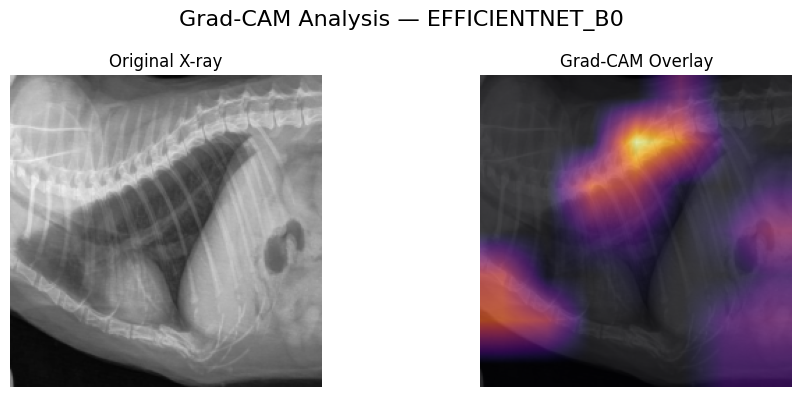

In [93]:
chosen_model_name = "efficientnet_b0"
img, _ = val_dataset[18]

_ = generate_gradcam(
    model=model,
    image_tensor=img,
    model_name=chosen_model_name,
    device=device,
    save_path=f"gradcam_{chosen_model_name}.png",
    show=True
)

In [94]:
# 📸 Grad-CAM pour une image par classe (0, 1, 2)
print("\n📸 Génération d'une image Grad-CAM pour chaque classe...")

# Sélectionner un exemple de chaque classe
example_indices = {0: None, 1: None, 2: None}
for i in range(len(val_dataset)):
    _, label = val_dataset[i]
    if example_indices[label] is None:
        example_indices[label] = i
    if all(v is not None for v in example_indices.values()):
        break

# Générer Grad-CAM pour chaque exemple
for cls, idx in example_indices.items():
    img, _ = val_dataset[idx]
    input_tensor = img.unsqueeze(0).to(device)
    input_tensor.requires_grad = True

    model.eval()
    out = model(input_tensor)
    pred_class = out.argmax(dim=1).item()

    activation_map = cam_extractor(pred_class, out)[0].detach().cpu().numpy().mean(axis=0)
    img_np = img.permute(1, 2, 0).cpu().numpy()
    img_np = np.clip(img_np, 0, 1)

    heatmap = np.maximum(activation_map, 0)
    heatmap = heatmap / (np.max(heatmap) + 1e-8)
    heatmap = cv2.resize(heatmap, (img_np.shape[1], img_np.shape[0]))
    colored_heatmap = cm.jet(np.squeeze(heatmap))[..., :3]
    superposed_img = 0.5 * img_np + 0.5 * colored_heatmap
    superposed_img = np.clip(superposed_img, 0, 1)

    # Sauvegarde
    plt.imsave(f"GradCAM_{chosen_model_name}_class{cls}.png", superposed_img)
    print(f"✅ Image sauvegardée : GradCAM_{chosen_model_name}_class{cls}.png")


📸 Génération d'une image Grad-CAM pour chaque classe...
✅ Image sauvegardée : GradCAM_efficientnet_b0_class0.png
✅ Image sauvegardée : GradCAM_efficientnet_b0_class1.png
✅ Image sauvegardée : GradCAM_efficientnet_b0_class2.png


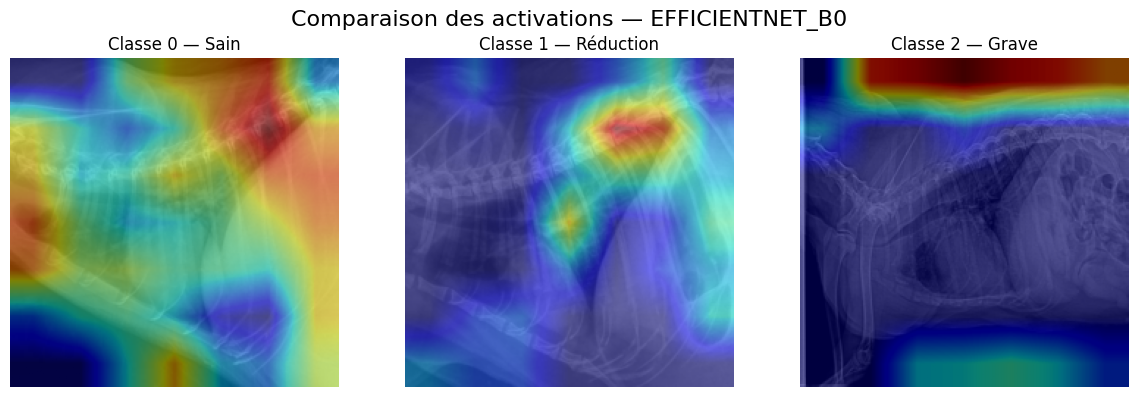

In [96]:
# 🎨 Comparaison visuelle
fig, axs = plt.subplots(1, 3, figsize=(12, 4))
titles = ["Classe 0 — Sain", "Classe 1 — Réduction", "Classe 2 — Grave"]

for i in range(3):
    img = plt.imread(f"GradCAM_{chosen_model_name}_class{i}.png")
    axs[i].imshow(img)
    axs[i].set_title(titles[i])
    axs[i].axis('off')

plt.suptitle(f"Comparaison des activations — {chosen_model_name.upper()}", fontsize=16)
plt.tight_layout()
plt.show()

Recommendation IA

In [107]:
import requests
try:
    r = requests.get("http://localhost:11434")
    print("✅ Serveur Ollama actif :", r.status_code)
except:
    print("❌ Serveur non joignable.")

✅ Serveur Ollama actif : 200


In [108]:
import requests

def get_ai_recommendation_mistral(prompt):
    url = "http://localhost:11434/api/generate"
    headers = {"Content-Type": "application/json"}
    data = {
        "model": "mistral",
        "prompt": prompt,
        "stream": False
    }
    response = requests.post(url, headers=headers, json=data)
    if response.status_code == 200:
        return response.json()["response"]
    else:
        return "Erreur de génération."

In [109]:
# Description clinique associée à chaque classe pour enrichir le prompt
classe_description = {
    0: "Radiographie montrant un cœur de taille normale, sans anomalies visibles. Aucun signe de cardiopathie détecté.",
    1: "Réduction légère de la silhouette cardiaque. Suspicion d'hypovolémie ou de troubles métaboliques.",
    2: "Cardiomégalie visible. Suspicion de pathologie cardiaque sérieuse (insuffisance cardiaque congestive, péricardite ou autre)."
}

classe_nom = {
    0: "sain",
    1: "réduction",
    2: "grave"
}

In [110]:
# 🧾 Construire dynamiquement le prompt enrichi
image_context = classe_description.get(pred_class, "Radiographie thoracique du chien.")
classe_text = classe_nom.get(pred_class, "inconnue")

prompt = (
    f"🩺 Contexte : Chien adulte, radiographie thoracique récente. "
    f"Analyse cette radiographie vétérinaire classée dans la catégorie **{classe_text.upper()}** (code {pred_class}).\n"
    f"📌 Détails cliniques : {image_context}\n\n"
    "✅ Donne une explication claire du diagnostic possible.\n"
    "💡 Propose ensuite **2 recommandations médicales concrètes** pour le vétérinaire.\n"
    "🧠 Sois professionnel, concis, orienté diagnostic & action."
)

# 🤖 Appel au modèle local Mistral
recommendation_ai = get_ai_recommendation_mistral(prompt)

# 📤 Affichage propre
print("💬 Recommandation IA enrichie :\n")
print(recommendation_ai)

💬 Recommandation IA enrichie :

 Diagnostic possible : La cardiomégalie visible dans la radiographie thoracique du chien peut indiquer une pathologie cardiaque sérieuse, comme l'insuffisance cardiaque congestive, une péricardite ou d'autres anomalies cardiaques. Il est donc nécessaire de réaliser des examens complémentaires pour confirmer le diagnostic :

1. Radiographie thoracique en position latérale gauche : elle permet de visualiser plus clairement l'anneau aortique et ainsi éliminer un éventuel tumorome cardiaque ou une hypertrophie ventriculaire droite qui pourraient expliquer la cardiomégalie.
2. Échographie cardiaque : elle permet de visualiser plus précisément l'activité contractile des chambres cardiaques et évaluer la fonction systolique et diastolique, ainsi que les valvules cardiaques et le péricarde. Cette méthode peut également permettre d'éliminer ou confirmer d'autres diagnoses, tels qu'une malformation congénitale ou une pathologie inflammatoire de la paroi du cœur.



In [111]:
# 🔍 Test simple de génération avec Mistral
test_prompt = (
    "Voici une radiographie vétérinaire classée dans la catégorie grave (cardiomégalie). "
    "Propose deux recommandations médicales concrètes au vétérinaire. Sois concis et professionnel."
)

# Appel test
test_response = get_ai_recommendation_mistral(test_prompt)

# Affichage
print("🧪 Résultat du test Mistral :")
print(test_response)

🧪 Résultat du test Mistral :
1. Recommandation 1: Imposer immédiatement un traitement diurétique pour réduire la charge cardiaque, améliorer le fonctionnement du foie et aider à la décongestion pulmonaire.

2. Recommandation 2: Effectuer une échographie cardiaque complète pour identifier précisément les causes de la cardiomégalie (hypertrophie ventriculaire, valvulopathie, etc.), ce qui permettra de définir le traitement optimal et suivre son évolution au fil du temps.


In [112]:
print("Classe prédite :", pred_class)
print("Prompt généré :\n", prompt)
print("Réponse IA :\n", recommendation_ai)

Classe prédite : 2
Prompt généré :
 🩺 Contexte : Chien adulte, radiographie thoracique récente. Analyse cette radiographie vétérinaire classée dans la catégorie **GRAVE** (code 2).
📌 Détails cliniques : Cardiomégalie visible. Suspicion de pathologie cardiaque sérieuse (insuffisance cardiaque congestive, péricardite ou autre).

✅ Donne une explication claire du diagnostic possible.
💡 Propose ensuite **2 recommandations médicales concrètes** pour le vétérinaire.
🧠 Sois professionnel, concis, orienté diagnostic & action.
Réponse IA :
  Diagnostic possible : La cardiomégalie visible dans la radiographie thoracique du chien peut indiquer une pathologie cardiaque sérieuse, comme l'insuffisance cardiaque congestive, une péricardite ou d'autres anomalies cardiaques. Il est donc nécessaire de réaliser des examens complémentaires pour confirmer le diagnostic :

1. Radiographie thoracique en position latérale gauche : elle permet de visualiser plus clairement l'anneau aortique et ainsi éliminer u

In [114]:
from matplotlib.backends.backend_pdf import PdfPages
from PIL import Image
import matplotlib.pyplot as plt

with PdfPages(f"XAI_Report_{chosen_model_name}.pdf") as pdf:

    # 🔍 1. Grad-CAM par classe
    for i in range(3):
        img = Image.open(f"GradCAM_{chosen_model_name}_class{i}.png")
        fig = plt.figure(figsize=(6, 6))
        plt.imshow(img)
        plt.title(f"Grad-CAM — Classe {i}", fontsize=14)
        plt.axis("off")
        pdf.savefig(fig)
        plt.close(fig)

    # 🧠 2. Page recommandation IA
    fig = plt.figure(figsize=(6, 6))
    plt.axis('off')
    plt.title("📋 Recommandation IA", fontsize=14, pad=20)

    # ✅ Format propre du texte IA
    if recommendation_ai:
        wrapped_text = "\n".join(recommendation_ai[i:i+90] for i in range(0, len(recommendation_ai), 90))
        plt.text(0.5, 0.5, wrapped_text, wrap=True, ha='center', va='center', fontsize=10)
    else:
        plt.text(0.5, 0.5, "❌ Recommandation IA non disponible.", ha='center', va='center', fontsize=12, color='red')

    pdf.savefig(fig)
    plt.close(fig)

print(f"✅ Rapport complet sauvegardé dans XAI_Report_{chosen_model_name}.pdf")

C:\Users\Dorra Sioud\AppData\Local\Temp\ipykernel_23792\2932329529.py:29: UserWarning: Glyph 128203 (\N{CLIPBOARD}) missing from font(s) DejaVu Sans.
  pdf.savefig(fig)


✅ Rapport complet sauvegardé dans XAI_Report_efficientnet_b0.pdf


In [119]:
import torch

# 🔧 1. Nettoyage des hooks résiduels (très important)
for module in model.modules():
    if hasattr(module, "_forward_hooks"):
        module._forward_hooks.clear()
    if hasattr(module, "_forward_pre_hooks"):
        module._forward_pre_hooks.clear()
    if hasattr(module, "_backward_hooks"):
        module._backward_hooks.clear()

print("✅ Hooks supprimés avec succès.")

# 📦 2. Préparer le modèle
model = model.to(device)
model.eval()

# 🧪 3. Exemple d’input factice
example_input = torch.randn(1, 3, 224, 224).to(device)

# 🔁 4. Exporter le modèle
try:
    traced_model = torch.jit.trace(model, example_input)
    traced_model.save("efficientnet_b0_traced.pt")
    print("✅ Modèle EfficientNet-B0 exporté avec succès en TorchScript (efficientnet_b0_traced.pt)")
except Exception as e:
    print("❌ Erreur pendant l’export TorchScript :", e)

✅ Hooks supprimés avec succès.
✅ Modèle EfficientNet-B0 exporté avec succès en TorchScript (efficientnet_b0_traced.pt)
